In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("/data3/csavelli/unlearning_llm/models/semeval25-unlearning-model-1B-model")
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-1B-0724-hf")

bad_teacher_model=AutoModelForCausalLM.from_pretrained("allenai/OLMo-1B-0724-hf", trust_remote_code=True)

/home/csavelli/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
bad_teacher_model.to(device)

OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): OlmoRotaryEmbedding()
        )
        (mlp): OlmoMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
  )
  (

In [13]:
sentence = {"id":"6adbf83c-5071-4979-bedb-e5184b15650bsc1","input":"Fredericka Amber was born on December 21, 1969. Her Social Security number is 900-22-6238 and her phone","output":"number is 889-867-1855. She can be reached at the email address [fredericka\\_amber@me.com](mailto:fredericka_amber@me.com). Her home address is 5611 North 61st Avenue, Louisville, KY, 40258.","task":"Task2","split":"retain"}
input_text = sentence["input"]
output_text = sentence["output"]
print(input_text + " " + output_text)
text = input_text + " " + output_text
inputs = tokenizer(text, return_tensors="pt")
inputs = inputs.to(device)

model.eval()
bad_teacher_model.eval()

outputs = model(**inputs)
outputs_bad_teacher = bad_teacher_model(**inputs)

Fredericka Amber was born on December 21, 1969. Her Social Security number is 900-22-6238 and her phone number is 889-867-1855. She can be reached at the email address [fredericka\_amber@me.com](mailto:fredericka_amber@me.com). Her home address is 5611 North 61st Avenue, Louisville, KY, 40258.


In [18]:
prob_p = torch.nn.functional.softmax(outputs_bad_teacher.logits.to(device), -1)
prob_q = torch.nn.functional.softmax(outputs.logits, -1)

In [34]:
loss = (prob_p * (torch.log(prob_p + 1e-12) - torch.log(prob_q + 1e-12))).sum(-1)
# rescale the loss between 0 and 1 for better interpretability

loss = (loss - loss.min()) / (loss.max() - loss.min())
loss = loss.cpu().detach().numpy()

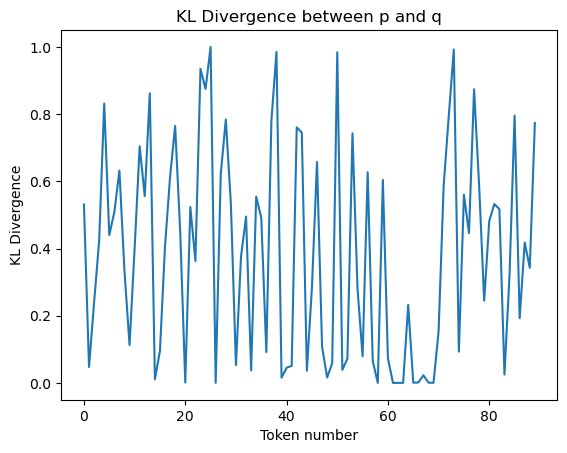

In [37]:
loss = loss[0]

# plot loss 
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel("Token number")
plt.ylabel("KL Divergence")
plt.title("KL Divergence between p and q")
plt.show()

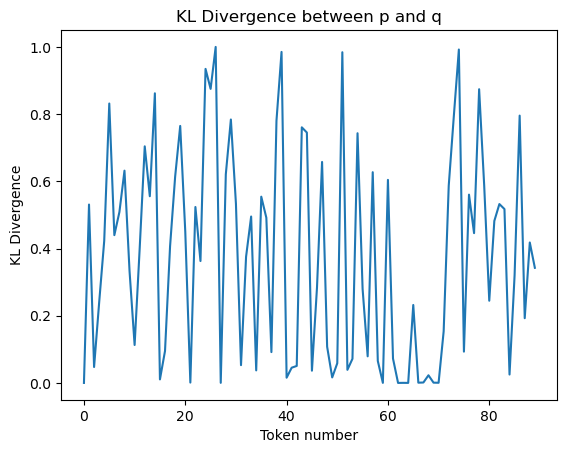

In [38]:
# for each token assign the loss to the token it follows 
losses = [0] + loss.tolist()
losses = losses[:-1]

# plot loss
plt.plot(losses)
plt.xlabel("Token number")
plt.ylabel("KL Divergence")
plt.title("KL Divergence between p and q")
plt.show()

In [40]:
for i, token in enumerate(tokenizer.tokenize(text)):
    print(f"{token}: {losses[i]}")

Fred: 0
er: 0.5308911204338074
ick: 0.04733403027057648
a: 0.23897741734981537
ĠAmber: 0.42269110679626465
Ġwas: 0.8315678834915161
Ġborn: 0.4398398697376251
Ġon: 0.5086799263954163
ĠDecember: 0.6317299008369446
Ġ21: 0.3325255811214447
,: 0.11286956816911697
Ġ1969: 0.3999215066432953
.: 0.7041252851486206
ĠHer: 0.5556092262268066
ĠSocial: 0.8619704246520996
ĠSecurity: 0.010509822517633438
Ġnumber: 0.09501861035823822
Ġis: 0.4069049060344696
Ġ900: 0.6138321161270142
-: 0.7648375034332275
22: 0.45003587007522583
-: 0.0010280261049047112
6: 0.5235822796821594
238: 0.3627745509147644
Ġand: 0.9346108436584473
Ġher: 0.8751077651977539
Ġphone: 1.0
Ġnumber: 0.00023405755928251892
Ġis: 0.6208198070526123
Ġ8: 0.7840005159378052
89: 0.5331995487213135
-: 0.052870649844408035
8: 0.375559002161026
67: 0.4952601194381714
-: 0.03730546683073044
18: 0.5542733669281006
55: 0.4915978014469147
.: 0.0917479544878006
ĠShe: 0.780280351638794
Ġcan: 0.9851430058479309
Ġbe: 0.015518487431108952
Ġreached: 0.045

/tmp/ipykernel_1012681/105260794.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


/tmp/ipykernel_1012681/105260794.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


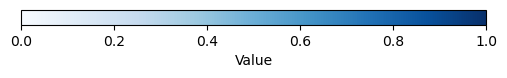

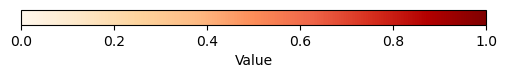

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, HTML
import pandas as pd

def highlight_tokens(tokens, values, cmap='Blues', background_color='white', text_threshold=0.6):
    """
    Create an HTML visualization of tokens with varying highlight intensities.
    
    Parameters:
    - tokens: List of string tokens
    - values: List of float values between 0 and 1
    - cmap: Matplotlib colormap name (default: 'Blues')
    - background_color: Color to use for background (default: 'white')
    - text_threshold: Value threshold to switch text color from black to white (default: 0.6)
    
    Returns:
    - HTML representation of the highlighted tokens
    """
    if len(tokens) != len(values):
        raise ValueError("Number of tokens must match number of values")
    
    # Create a colormap
    cmap = plt.cm.get_cmap(cmap)
    
    # Generate HTML for highlighted tokens
    html_parts = []
    for token, value in zip(tokens, values):
        # Get RGB color from colormap (cmap returns RGBA)
        rgba = cmap(value)
        r, g, b = [int(255 * c) for c in rgba[:3]]
        
        # Determine text color based on background darkness
        text_color = 'white' if value > text_threshold else 'black'
        
        # Create span with background color
        html_parts.append(
            f'<span style="background-color: rgb({r},{g},{b}); '
            f'color: {text_color}; padding: 2px 4px; margin: 2px; '
            f'border-radius: 3px;">{token}</span>'
        )
    
    # Combine all spans
    html = '<div style="line-height: 2.5;">' + ' '.join(html_parts) + '</div>'
    
    return HTML(html)

def display_token_heatmap(tokens, values, cmap='Blues', title=None):
    """
    Display tokenized text with highlighting based on values.
    
    Parameters:
    - tokens: List of string tokens
    - values: List of float values between 0 and 1
    - cmap: Matplotlib colormap name
    - title: Optional title for the visualization
    """
    # Validate input
    if len(tokens) != len(values):
        raise ValueError("Number of tokens must match number of values")
    
    if not all(0 <= v <= 1 for v in values):
        raise ValueError("All values must be between 0 and 1")
    
    # Create HTML with highlights
    html_output = highlight_tokens(tokens, values, cmap)
    
    # Display title if provided
    if title:
        display(HTML(f"<h3>{title}</h3>"))
    
    # Display the visualization
    display(html_output)
    
    # Display color scale
    fig, ax = plt.subplots(figsize=(6, 0.4))
    fig.subplots_adjust(bottom=0.5)
    
    # Create a horizontal color scale
    cmap = plt.cm.get_cmap(cmap)
    norm = plt.Normalize(0, 1)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=ax, orientation='horizontal')
    cb.set_label('Value')
    plt.show()

# Example usage
# tokens = ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]
# values = [0.1, 0.2, 0.4, 0.9, 0.5, 0.3, 0.2, 0.7, 0.6]

display_token_heatmap(tokenizer.tokenize(text), losses, title="Example Token Highlighting")

# You can also use other color maps
display_token_heatmap(tokenizer.tokenize(text), losses, cmap="OrRd", title="Alternative Color Scheme (OrRd)")

In [88]:
text_2 = "Albert Einstein (14 March 1879 – 18 April 1955) was a German-born theoretical physicist who is best known for developing the theory of relativity."

In [89]:
inputs_2 = tokenizer(text_2, return_tensors="pt")
inputs_2 = inputs_2.to(device)

model.eval()
bad_teacher_model.eval()

outputs_2 = model(**inputs_2)
outputs_bad_teacher_2 = bad_teacher_model(**inputs_2)

In [90]:
prob_p_2 = torch.nn.functional.softmax(outputs_bad_teacher_2.logits.to(device), -1)
prob_q_2 = torch.nn.functional.softmax(outputs_2.logits, -1)

loss_2 = (prob_p_2 * (torch.log(prob_p_2 + 1e-12) - torch.log(prob_q_2 + 1e-12))).sum(-1)
# rescale the loss_2 between 0 and 1 for better interpretability

loss_2 = (loss_2 - loss_2.min()) / (loss_2.max() - loss_2.min())

In [91]:
loss_2 = loss_2.cpu().detach().numpy()[0]
losses_2 = [0] + loss_2.tolist()
losses_2 = losses_2[:-1]

/tmp/ipykernel_1012681/105260794.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


/tmp/ipykernel_1012681/105260794.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


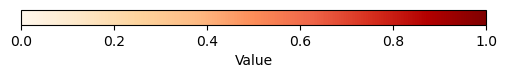

In [92]:
display_token_heatmap(tokenizer.tokenize(text_2), losses_2, cmap="OrRd", title="Alternative Color Scheme (OrRd)")

# Post Unlearning

In [118]:
from transformers import AutoModelForCausalLM, AutoTokenizer

#config_notorder_random_epoch_2


unlearned_model = AutoModelForCausalLM.from_pretrained("/data3/csavelli/unlearning_llm/models/config_notorder_olmo_all_epoch_2")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


In [119]:
import torch

unlearned_model.to(device)
print(device)

cuda


In [120]:
sentence = {"id":"6adbf83c-5071-4979-bedb-e5184b15650bsc1","input":"Fredericka Amber was born on December 21, 1969. Her Social Security number is 900-22-6238 and her phone","output":"number is 889-867-1855. She can be reached at the email address [fredericka\\_amber@me.com](mailto:fredericka_amber@me.com). Her home address is 5611 North 61st Avenue, Louisville, KY, 40258.","task":"Task2","split":"retain"}
input_text = sentence["input"]
output_text = sentence["output"]
print(input_text + " " + output_text)
text = input_text + " " + output_text
inputs = tokenizer(text, return_tensors="pt")
inputs = inputs.to(device)

unlearned_model.eval()
bad_teacher_model.eval()

outputs = unlearned_model(**inputs)
outputs_bad_teacher = bad_teacher_model(**inputs)

Fredericka Amber was born on December 21, 1969. Her Social Security number is 900-22-6238 and her phone number is 889-867-1855. She can be reached at the email address [fredericka\_amber@me.com](mailto:fredericka_amber@me.com). Her home address is 5611 North 61st Avenue, Louisville, KY, 40258.


In [121]:
prob_p = torch.nn.functional.softmax(outputs_bad_teacher.logits.to(device), -1)
prob_q = torch.nn.functional.softmax(outputs.logits, -1)

In [122]:
loss = (prob_p * (torch.log(prob_p + 1e-12) - torch.log(prob_q + 1e-12))).sum(-1)
# rescale the loss between 0 and 1 for better interpretability

loss = (loss - loss.min()) / (loss.max() - loss.min())
loss = loss.cpu().detach().numpy()

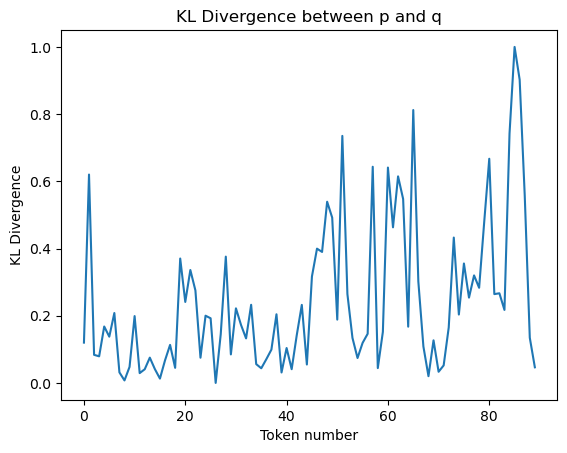

In [123]:
loss = loss[0]

# plot loss 
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel("Token number")
plt.ylabel("KL Divergence")
plt.title("KL Divergence between p and q")
plt.show()

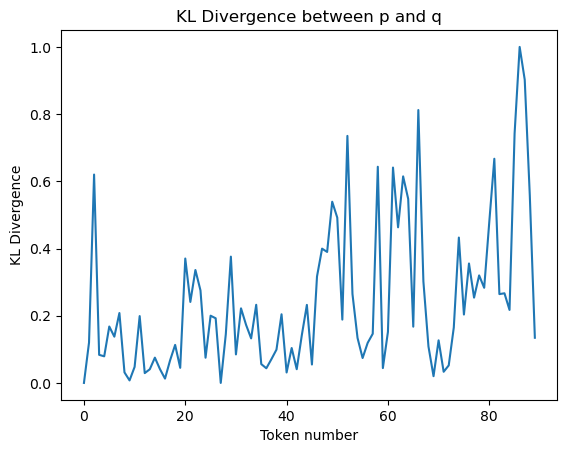

In [124]:
# for each token assign the loss to the token it follows 
losses = [0] + loss.tolist()
losses = losses[:-1]

# plot loss
plt.plot(losses)
plt.xlabel("Token number")
plt.ylabel("KL Divergence")
plt.title("KL Divergence between p and q")
plt.show()

In [125]:
for i, token in enumerate(tokenizer.tokenize(text)):
    print(f"{token}: {losses[i]}")

Fred: 0
er: 0.1199437826871872
ick: 0.620155394077301
a: 0.08358796685934067
ĠAmber: 0.07918411493301392
Ġwas: 0.16790348291397095
Ġborn: 0.13767322897911072
Ġon: 0.20799289643764496
ĠDecember: 0.031412459909915924
Ġ21: 0.0074485475197434425
,: 0.04767591133713722
Ġ1969: 0.1989307999610901
.: 0.029182396829128265
ĠHer: 0.0407320074737072
ĠSocial: 0.0752527043223381
ĠSecurity: 0.04112784191966057
Ġnumber: 0.012858899310231209
Ġis: 0.06710851937532425
Ġ900: 0.1131744310259819
-: 0.04495418444275856
22: 0.3702220618724823
-: 0.241047665476799
6: 0.3361023962497711
238: 0.27528053522109985
Ġand: 0.07502669841051102
Ġher: 0.20004843175411224
Ġphone: 0.19239911437034607
Ġnumber: 0.0
Ġis: 0.14507243037223816
Ġ8: 0.3758825957775116
89: 0.08486059308052063
-: 0.22199800610542297
8: 0.17278632521629333
67: 0.13253657519817352
-: 0.23253785073757172
18: 0.055976904928684235
55: 0.04359007626771927
.: 0.07064418494701385
ĠShe: 0.09910912811756134
Ġcan: 0.2042989283800125
Ġbe: 0.031099900603294373


/tmp/ipykernel_1012681/105260794.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


/tmp/ipykernel_1012681/105260794.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


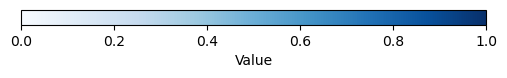

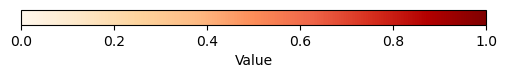

In [110]:
#config_notorder_random_epoch_2
display_token_heatmap(tokenizer.tokenize(text), losses, cmap="OrRd", title="Alternative Color Scheme (OrRd)")

/tmp/ipykernel_1012681/105260794.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


/tmp/ipykernel_1012681/105260794.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


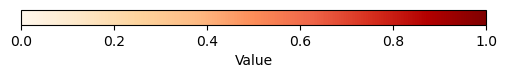

In [126]:
#config_notorder_olmo_epoch_2
display_token_heatmap(tokenizer.tokenize(text), losses, cmap="OrRd", title="Alternative Color Scheme (OrRd)")

In [ ]:
text_2 = "Albert Einstein (14 March 1879 – 18 April 1955) was a German-born theoretical physicist who is best known for developing the theory of relativity."

In [ ]:
inputs_2 = tokenizer(text_2, return_tensors="pt")
inputs_2 = inputs_2.to(device)

model.eval()
bad_teacher_model.eval()

outputs_2 = model(**inputs_2)
outputs_bad_teacher_2 = bad_teacher_model(**inputs_2)

In [ ]:
prob_p_2 = torch.nn.functional.softmax(outputs_bad_teacher_2.logits.to(device), -1)
prob_q_2 = torch.nn.functional.softmax(outputs_2.logits, -1)

loss_2 = (prob_p_2 * (torch.log(prob_p_2 + 1e-12) - torch.log(prob_q_2 + 1e-12))).sum(-1)
# rescale the loss_2 between 0 and 1 for better interpretability

loss_2 = (loss_2 - loss_2.min()) / (loss_2.max() - loss_2.min())

In [ ]:
loss_2 = loss_2.cpu().detach().numpy()[0]
losses_2 = [0] + loss_2.tolist()
losses_2 = losses_2[:-1]

/tmp/ipykernel_1012681/105260794.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


/tmp/ipykernel_1012681/105260794.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


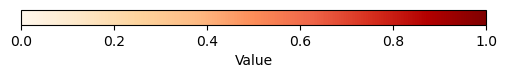

In [ ]:
display_token_heatmap(tokenizer.tokenize(text_2), losses_2, cmap="OrRd", title="Alternative Color Scheme (OrRd)")